<div >
<img src = "../banner.jpg" />
</div>

# Desbalance de Clases Extremo: Fraude

En este tutorial nos centraremos en detectar [fraude en tarjetas de crédito](https://www.kaggle.com/mlg-ulb/creditcardfraud). Los datos que utilizaremos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está muy desequilibrado: la clase positiva (fraudes) representa el 0,172% de todas las transacciones. Esta base de datos suele utilizarse como "benchmark" para los estudios de desbalances de clases.


## Configuración Inicial

In [1]:
#Cargar librerías 
require("pacman")

p_load("tidyverse",
       "glmnet",
        "caret")


Loading required package: pacman



## Datos
Los datos que vamos a usar en esta sección son  datos de detección de fraude en tarjetas de crédito que están alojados en google.

Esta base de datos solo contiene variables numéricas que son el resultado de una transformación PCA. Lamentablemente, debido a cuestiones de confidencialidad, no se difunden las características originales ni más información general sobre los datos. Las características V1, V2,… V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' (`Time`) y 'Cantidad' (`Amount`). La variable `Time` contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La variable `Amount`  es el monto de la transacción; esta variable se puede utilizar para el aprendizaje sensible a los costos, por ejemplo. La característica 'Clase' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.


In [2]:
# cargar datos
fraud <- read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

# Ver las primeras filas del dataframe.
head(fraud)

Rows: 284807 Columns: 31
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (31): Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


In [3]:
# Veamos cómo se distribuye la variable de interés.
fraud<- fraud %>% mutate(Fraude = factor(Class,levels=c(0,1),labels=c("Negativo","Positivo")))
table(fraud$Fraude)



Negativo Positivo 
  284315      492 

In [4]:
prop.table(table(fraud$Fraude))


   Negativo    Positivo 
0.998272514 0.001727486 

In [5]:
data<- fraud  %>% group_by(Fraude) %>% tally()

In [6]:
data

Fraude,n
<fct>,<int>
Negativo,284315
Positivo,492


Saving 7 x 7 in image


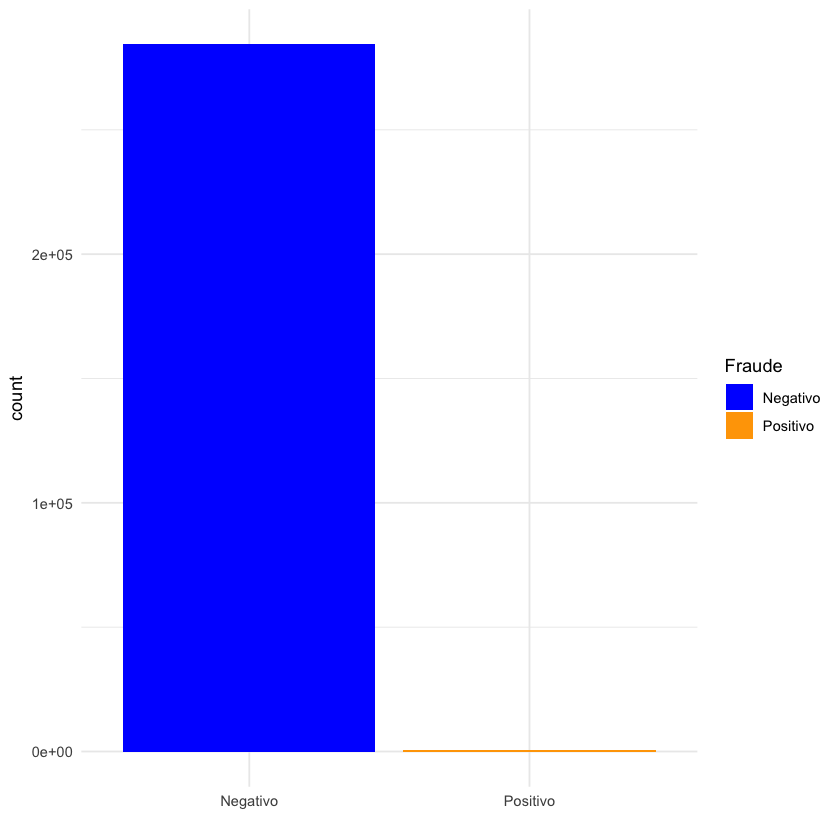

In [7]:
ggplot(data,aes(x = Fraude, y = n, fill = Fraude)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = c("Positivo" = "orange", "Negativo" = "blue")) + # Colors can be changed
  labs(x = "", y = "count") # Customize axis labels if needed


Menos del 1% de los casos es fraude. Las dos clases: fraude y no fraude están desbalanceadas, esto implica un reto grande para nuestros modelos de predicción, pues naturalmente tenderán a predecir que los casos no son fraude, dada la poca información que hay de los fraudes. Sin embargo, lo que más nos interesa en este caso es predecir los fraudes.


## Limpiar y dividir la muestra

Los datos crudos tienen un par de problemas : las columnas  `Time` y `Amount` tiene mucha varianza. Vamos eliminar la columna `Time` (ya que no será muy útil) y vamos a tomar el logaritmo de `Amount`.


In [8]:
# Eliminar las columnas 'Class' 'Time'
fraud<- fraud  %>% select(-Class,-Time)


# Convertir 'Amount' a  logs
fraud<- fraud  %>% mutate(Log_Amount = log(Amount + 0.001)) %>% select(-Amount)


### División de la muestra

- El objetivo es predecir bien fuera de muestra

- No queremos sobreajustar a la muestra
  
- Vamos a definir 2 bases

  - Muestra de entrenamiento: vamos a estimar los modelos, buscar parámetros, etc.
  
  -  Muestra de prueba que solo vamos a usar para evaluar los modelos


In [11]:
# Dividir los datos en conjuntos de entrenamiento (train), validación (val) y prueba (test)
set.seed(123) # Para reproducibilidad


train_indices <- as.integer(createDataPartition(fraud$Fraude, p = 0.8, list = FALSE))
train <- fraud[train_indices, ]
test <- fraud[-train_indices, ]

dim(train)


[1] 227846     30

In [12]:
dim(test)

[1] 56961    30

In [38]:
table(train$Fraude)


Negativo Positivo 
  227452      394 

In [13]:
prop.table(table(train$Fraude))


   Negativo    Positivo 
0.998270762 0.001729238 

In [37]:
table(test$Fraude)


Negativo Positivo 
   56863       98 

In [14]:
prop.table(table(test$Fraude))


   Negativo    Positivo 
0.998279525 0.001720475 

Note que la proporción de fraudes se preserva casi intacta para los conjuntos de entrenamiento, validacion y test. Esto no siempre suele ser el caso cuando las clases están tan desbalanceadas.


# Logit

If you have an imbalanced data set, first try training on the true distribution. If the model works well and generalizes, you're done! If not, try  resampling techniques.

In [15]:
ctrl<- trainControl(method = "cv",
                     number = 5,
                     classProbs = TRUE,
                     verbose=FALSE,
                     savePredictions = T)


In [18]:
#logit
set.seed(1410)
fraude_logit_orig <- train(Fraude~., 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")

fraude_logit_orig

Generalized Linear Model 

227846 samples
    29 predictor
     2 classes: 'Negativo', 'Positivo' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 182276, 182278, 182276, 182277, 182277 
Resampling results:

  Accuracy   Kappa    
  0.9991837  0.7217635


In [34]:
test<- test  %>% mutate(fraude_hat_logit_orig=predict(fraude_logit_orig,newdata = test,
                           type = "raw"))

In [36]:
confusionMatrix(data = test$fraude_hat_logit_orig, 
                reference = test$Fraude, positive="Positivo", mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction Negativo Positivo
  Negativo    56849       33
  Positivo       14       65
                                          
               Accuracy : 0.9992          
                 95% CI : (0.9989, 0.9994)
    No Information Rate : 0.9983          
    P-Value [Acc > NIR] : 7.593e-09       
                                          
                  Kappa : 0.7341          
                                          
 Mcnemar's Test P-Value : 0.00865         
                                          
              Precision : 0.822785        
                 Recall : 0.663265        
                     F1 : 0.734463        
             Prevalence : 0.001720        
         Detection Rate : 0.001141        
   Detection Prevalence : 0.001387        
      Balanced Accuracy : 0.831510        
                                          
       'Positive' Class : Positivo        
                                          

## Remuestreo

Hay varios enfoques:

    1. Up-sampling.  Simulates or imputes additional data points of the minority class to improve balance across classes, while 
    2. Down-sampling. Randomly reduces the number of the majority class  to improve the balance across classes.
    3. Híbrido: 
        3.1 SMOTE
        3.2 ROSE

<div >
<img src = "sampling_methods.png" />
</div>

### Up Sampling

In [41]:
set.seed(1103)
upSampledTrain <- upSample(x = train,
                           y = train$Fraude,
                           ## keep the class variable name the same:
                           yname = "Fraude")
dim(train)

dim(upSampledTrain)

table(upSampledTrain$Fraude)


[1] 227846     30

[1] 454904     31


Negativo Positivo 
  227452   227452 

In [42]:

set.seed(1410)

fraude_logit_upsample <- train(Fraude~., 
                       data = upSampledTrain, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")

fraude_logit_upsample



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Generalized Linear Model 

454904 samples
    29 predictor
     2 classes: 'Negativo', 'Positivo' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 363923, 363924, 363922, 363923, 363924 
Resampling results:

  Accuracy   Kappa   
  0.9473955  0.894791


### Down Sampling

In [43]:

set.seed(1103)
downSampledTrain <- downSample(x = train,
                           y = train$Fraude,
                           ## keep the class variable name the same:
                           yname = "Fraude")
dim(train)

dim(downSampledTrain)

table(downSampledTrain$Fraude)


ERROR: Error in eval(expr, envir, enclos): object 'training' not found


In [44]:
set.seed(1410)

fraude_logit_downsample <- train(Fraude~., 
                       data = downSampledTrain, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")

fraude_logit_downsample


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Generalized Linear Model 

788 samples
 29 predictor
  2 classes: 'Negativo', 'Positivo' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 631, 631, 630, 630, 630 
Resampling results:

  Accuracy   Kappa   
  0.9352576  0.870518


### SMOTE

<div >
<img src = "smote.png" />
</div>

In [45]:
p_load("smotefamily")

predictors<-colnames(train  %>% select(-Fraude))
head( train[predictors])


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_Amount
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.3598071,-0.07278117,2.53634674,1.3781552,-0.33832077,0.46238778,0.239598554,0.09869790,0.3637870,0.09079417,⋯,0.25141210,-0.01830678,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.021053053,5.0081054
1.1918571,0.26615071,0.16648011,0.4481541,0.06001765,-0.08236081,-0.078802983,0.08510165,-0.2554251,-0.16697441,⋯,-0.06908314,-0.22577525,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.014724169,0.9899129
-1.3583541,-1.34016307,1.77320934,0.3797796,-0.50319813,1.80049938,0.791460956,0.24767579,-1.5146543,0.20764287,⋯,0.52497973,0.24799815,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.059751841,5.9366413
-0.9662717,-0.18522601,1.79299334,-0.8632913,-0.01030888,1.24720317,0.237608940,0.37743587,-1.3870241,-0.05495192,⋯,-0.20803778,-0.10830045,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.061457629,4.8162493
1.2296576,0.14100351,0.04537077,1.2026127,0.19188099,0.27270812,-0.005159003,0.08121294,0.4649600,-0.09925432,⋯,-0.21963255,-0.16771627,-0.270709726,-0.15410379,-0.78005542,0.7501369,-0.2572368,0.034507430,0.005167769,1.6076363
-0.6442694,1.41796355,1.07438038,-0.4921990,0.94893409,0.42811846,1.120631358,-3.80786424,0.6153747,1.24937618,⋯,-0.15674185,1.94346534,-1.015454710,0.05750353,-0.64970901,-0.4152666,-0.0516343,-1.206921081,-1.085339188,3.7087066


In [46]:
smote_output = SMOTE(X = train[predictors],
                     target = train$Fraude)
smote_data = smote_output$data


In [48]:
table(train$Fraude)
table(smote_data$class)


Negativo Positivo 
  227452      394 


Negativo Positivo 
  227452   227338 

In [49]:
set.seed(1410)

fraude_logit_smote <- train(class~., 
                       data = smote_data, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")

fraude_logit_smote



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Generalized Linear Model 

454790 samples
    29 predictor
     2 classes: 'Negativo', 'Positivo' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 363831, 363833, 363831, 363832, 363833 
Resampling results:

  Accuracy   Kappa   
  0.9461378  0.892274


ROSE uses smoothed bootstrapping to draw artificial samples from the feature space neighbourhood around the minority class.

In [ ]:
# p_load(ROSE)

# set.seed(9560)
# rose_train <- ROSE(Frude ~ ., data  = training)$data                         
# table(rose_train$Class) 

In [ ]:
# set.seed(1410)

# fraude_logit_rose <- train(class~., 
#                        data = rose_train, 
#                        method = "glm",
#                        trControl = ctrl,
#                        family = "binomial")

# fraude_logit_rose


# Test set Performance



In [50]:
test<- test  %>% mutate(fraude_hat_smote_orig=predict(fraude_logit_smote,newdata = test,
                           type = "raw"))

In [51]:
confusionMatrix(data = test$fraude_hat_logit_orig, 
                reference = test$Fraude, positive="Positivo", mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction Negativo Positivo
  Negativo    56849       33
  Positivo       14       65
                                          
               Accuracy : 0.9992          
                 95% CI : (0.9989, 0.9994)
    No Information Rate : 0.9983          
    P-Value [Acc > NIR] : 7.593e-09       
                                          
                  Kappa : 0.7341          
                                          
 Mcnemar's Test P-Value : 0.00865         
                                          
              Precision : 0.822785        
                 Recall : 0.663265        
                     F1 : 0.734463        
             Prevalence : 0.001720        
         Detection Rate : 0.001141        
   Detection Prevalence : 0.001387        
      Balanced Accuracy : 0.831510        
                                          
       'Positive' Class : Positivo        
                                          

In [52]:
confusionMatrix(data = test$fraude_hat_smote_orig, 
                reference = test$Fraude, positive="Positivo", mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction Negativo Positivo
  Negativo    55384        7
  Positivo     1479       91
                                          
               Accuracy : 0.9739          
                 95% CI : (0.9726, 0.9752)
    No Information Rate : 0.9983          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1062          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.057962        
                 Recall : 0.928571        
                     F1 : 0.109113        
             Prevalence : 0.001720        
         Detection Rate : 0.001598        
   Detection Prevalence : 0.027563        
      Balanced Accuracy : 0.951281        
                                          
       'Positive' Class : Positivo        
                                          